In [ ]:
import pandas as pd
import numpy as np

import io
from io import BytesIO

from IPython.display import Image

from google.colab import drive
from google.colab import files

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib_inline.backend_inline

import statistics
from scipy.stats import wilcoxon

import math

In [ ]:
# Specify the "Colab Notebooks" subfolder of the Google Driver directory that contains the data of your experiment
## If you want to work directly in the "Colba Notebooks" directory, leave the '' brackets empty
colab_sub_folder = '/ERAL Lab/Paper 001/Reproducibility Folder'

# Specify the string to begin the names of the generated files
experiment_name = 'Scenario_1'

# Specify the name of the .csv file containing the data to be processed and its separator character
file_name = experiment_name + '.csv'
separator = ';'

# Specify the interval for "evals" quantization
delta_quantization = 100

# Set alpha for wilcoxon test
level_significance = 0.01

# Set the efficiency percentile reference
efficiency_percentile_reference = 0.75

In [ ]:
# Mount drive
drive.mount('/content/drive')
directory = 'drive/MyDrive/Colab Notebooks' + colab_sub_folder
%cd {directory}

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/ERAL Lab/Paper 001/Reproducibility Folder


In [ ]:
# Read the .csv with the data
fileCSV = pd.read_csv(file_name, sep = separator)
fileCSV

seed                  problem solver_sigma  iterations  evals  \
0           1  ea.p.s.pointAiming-20-1        cmaEs           1     12   
1           6  ea.p.s.pointAiming-20-1        cmaEs           1     12   
2           7  ea.p.s.pointAiming-20-1        cmaEs           1     12   
3           5  ea.p.s.pointAiming-20-1        cmaEs           1     12   
4           8  ea.p.s.pointAiming-20-1        cmaEs           1     12   
...       ...                      ...          ...         ...    ...   
2281135    30   ea.p.s.sphere-500-null          pso          95   9600   
2281136    30   ea.p.s.sphere-500-null          pso          96   9700   
2281137    30   ea.p.s.sphere-500-null          pso          97   9800   
2281138    30   ea.p.s.sphere-500-null          pso          98   9900   
2281139    30   ea.p.s.sphere-500-null          pso          99  10000   

         births  elapsed.seconds  all→size  firsts→size  lasts→size  \
0            12            0.071        12            1           1   
1            12            0.071        12            1           1   
2            12            0.071        12            1           1   
3            12            0.071        12            1           1   
4            12            0.071        12            1           1   
...         ...              ...       ...          ...         ...   
2281135    9600            3.638       100            1           1   
2281136    9700            3.645       100            1           1   
2281137    9800            3.651       100            1           1   
2281138    9900            3.659       100            1           1   
2281139   10000            3.667       100            1           1   

         all→each[genotype]→uniqueness  all→each[solution]→uniqueness  \
0                                  1.0                            1.0   
1                                  1.0                            1.0   
2                                  1.0                            1.0   
3                                  1.0                            1.0   
4                                  1.0                            1.0   
...                                ...                            ...   
2281135                            1.0                            1.0   
2281136                            1.0                            1.0   
2281137                            1.0                            1.0   
2281138                            1.0                            1.0   
2281139                            1.0                            1.0   

         all→each[fitness]→uniqueness  best→fitness  
0                                 1.0      5.155575  
1                                 1.0      4.624761  
2                                 1.0      4.707477  
3                                 1.0      4.229262  
4                                 1.0      4.212720  
...                               ...           ...  
2281135                           1.0     11.959066  
2281136                           1.0     11.949392  
2281137                           1.0     11.937114  
2281138                           1.0     11.916312  
2281139                           1.0     11.899757  

[2281140 rows x 14 columns]

In [ ]:
# Change some column names and create some new columns for code clarity

fileCSV['solver'] = fileCSV['solver_sigma'].str.split('-').str[0]

fileCSV['sigma'] = fileCSV['solver_sigma'].str.split('-').str[1]
fileCSV['sigma'] = np.where(fileCSV['sigma'].isna(), fileCSV['solver'], fileCSV['sigma'])

fileCSV['solver_sigma_seed'] = fileCSV['solver_sigma'] + "_seed:" + fileCSV['seed'].astype(str)

fileCSV['objective'] = "minimize"

best_fitness = list(filter(lambda x: 'best→fitness' in x, list(fileCSV.columns)))
fileCSV.rename(columns = {best_fitness[0]:'best_fitness'}, inplace = True)

fileCSV['evals_quantized'] = fileCSV['evals'].astype(int) // delta_quantization

fileCSV['genotype_size'] = fileCSV['problem'].str.extract('-(\d+)-').astype(int)

In [ ]:
united_CSV = fileCSV.copy()
united_CSV

seed                  problem solver_sigma  iterations  evals  \
0           1  ea.p.s.pointAiming-20-1        cmaEs           1     12   
1           6  ea.p.s.pointAiming-20-1        cmaEs           1     12   
2           7  ea.p.s.pointAiming-20-1        cmaEs           1     12   
3           5  ea.p.s.pointAiming-20-1        cmaEs           1     12   
4           8  ea.p.s.pointAiming-20-1        cmaEs           1     12   
...       ...                      ...          ...         ...    ...   
2281135    30   ea.p.s.sphere-500-null          pso          95   9600   
2281136    30   ea.p.s.sphere-500-null          pso          96   9700   
2281137    30   ea.p.s.sphere-500-null          pso          97   9800   
2281138    30   ea.p.s.sphere-500-null          pso          98   9900   
2281139    30   ea.p.s.sphere-500-null          pso          99  10000   

         births  elapsed.seconds  all→size  firsts→size  lasts→size  \
0            12            0.071        12            1           1   
1            12            0.071        12            1           1   
2            12            0.071        12            1           1   
3            12            0.071        12            1           1   
4            12            0.071        12            1           1   
...         ...              ...       ...          ...         ...   
2281135    9600            3.638       100            1           1   
2281136    9700            3.645       100            1           1   
2281137    9800            3.651       100            1           1   
2281138    9900            3.659       100            1           1   
2281139   10000            3.667       100            1           1   

         all→each[genotype]→uniqueness  all→each[solution]→uniqueness  \
0                                  1.0                            1.0   
1                                  1.0                            1.0   
2                                  1.0                            1.0   
3                                  1.0                            1.0   
4                                  1.0                            1.0   
...                                ...                            ...   
2281135                            1.0                            1.0   
2281136                            1.0                            1.0   
2281137                            1.0                            1.0   
2281138                            1.0                            1.0   
2281139                            1.0                            1.0   

         all→each[fitness]→uniqueness  best_fitness solver  sigma  \
0                                 1.0      5.155575  cmaEs  cmaEs   
1                                 1.0      4.624761  cmaEs  cmaEs   
2                                 1.0      4.707477  cmaEs  cmaEs   
3                                 1.0      4.229262  cmaEs  cmaEs   
4                                 1.0      4.212720  cmaEs  cmaEs   
...                               ...           ...    ...    ...   
2281135                           1.0     11.959066    pso    pso   
2281136                           1.0     11.949392    pso    pso   
2281137                           1.0     11.937114    pso    pso   
2281138                           1.0     11.916312    pso    pso   
2281139                           1.0     11.899757    pso    pso   

        solver_sigma_seed objective  evals_quantized  genotype_size  
0            cmaEs_seed:1  minimize                0             20  
1            cmaEs_seed:6  minimize                0             20  
2            cmaEs_seed:7  minimize                0             20  
3            cmaEs_seed:5  minimize                0             20  
4            cmaEs_seed:8  minimize                0             20  
...                   ...       ...              ...            ...  
2281135       pso_seed:30  minimize               96            500  
2

In [ ]:
# Create a list of all different problems, solvers, sigmas, solvers_sigmas, seeds, solvers_sigmas_seeds

problems = sorted(united_CSV['problem'].drop_duplicates().tolist())
solvers = sorted(united_CSV['solver'].drop_duplicates().tolist())
sigmas = sorted(united_CSV['sigma'].drop_duplicates().tolist())
solvers_sigmas = sorted(united_CSV['solver_sigma'].drop_duplicates().tolist())
seeds = sorted(united_CSV['seed'].drop_duplicates().tolist())
solvers_sigmas_seeds = sorted(united_CSV['solver_sigma_seed'].drop_duplicates().tolist())

print('{:15s}{} {}'.format('problems', ':', problems))
print('{:15s}{} {}'.format('solvers', ':', solvers))
print('{:15s}{} {}'.format('sigmas', ':', sigmas))
print('{:15s}{} {}'.format('solvers_sigmas', ':', solvers_sigmas))
print('{:15s}{} {}'.format('seeds', ':', seeds))
print('{:15s}{} {}'.format('solver_sigma_seed', ':', solvers_sigmas_seeds))

problems       : ['ea.p.s.ackley-100-null', 'ea.p.s.ackley-20-null', 'ea.p.s.ackley-200-null', 'ea.p.s.ackley-500-null', 'ea.p.s.circularPointsAiming-100-null', 'ea.p.s.circularPointsAiming-20-null', 'ea.p.s.circularPointsAiming-200-null', 'ea.p.s.circularPointsAiming-500-null', 'ea.p.s.pointAiming-100-1', 'ea.p.s.pointAiming-100-10', 'ea.p.s.pointAiming-20-1', 'ea.p.s.pointAiming-20-10', 'ea.p.s.pointAiming-200-1', 'ea.p.s.pointAiming-200-10', 'ea.p.s.pointAiming-500-1', 'ea.p.s.pointAiming-500-10', 'ea.p.s.rastrigin-100-null', 'ea.p.s.rastrigin-20-null', 'ea.p.s.rastrigin-200-null', 'ea.p.s.rastrigin-500-null', 'ea.p.s.sphere-100-null', 'ea.p.s.sphere-20-null', 'ea.p.s.sphere-200-null', 'ea.p.s.sphere-500-null']
solvers        : ['cmaEs', 'de', 'ga', 'pso', 'simpleEs']
sigmas         : ['0.02', '0.25', '0.5', 'cmaEs', 'de', 'pso']
solvers_sigmas : ['cmaEs', 'de', 'ga-0.02', 'ga-0.25', 'ga-0.5', 'pso', 'simpleEs-0.02', 'simpleEs-0.25', 'simpleEs-0.5']
seeds          : [1, 2, 3, 4, 5, 

In [ ]:
# Images style settings
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
plt.rcParams.update({'font.size': 6, "lines.linewidth": 0.1})

# Set colormap
color_map = mpl.colormaps['tab10']

In [ ]:
################################################################################
# Convergence plots

# Some image settings
fig, axs = plt.subplots(len(problems), len(solvers), sharex=True, sharey='row', layout='constrained', figsize=(2.2*len(solvers), len(problems)))
fig.suptitle('Convergence plots', fontsize=12, fontweight='bold')
fig.supxlabel('x = Evals', fontsize=8, fontweight='bold')
fig.supylabel('y = Best Fitness', fontsize=8, fontweight='bold')

for i, problem in enumerate(problems):

  # Specify the "problem" to the right of each row of plots
  axs[i, len(solvers)-1].yaxis.set_label_position("right")
  axs[i, len(solvers)-1].set_ylabel(problem, rotation='horizontal', labelpad=10, horizontalalignment='left')

  # Filter rows of the current problem
  pre_pre_filtered_data = united_CSV[united_CSV['problem'] == problem]

  for j, solver in enumerate(solvers):

    # Specify the "solver" at the top of plots
    axs[0, j].set_title(solver, pad=10, rotation=10, weight='bold')

    colors = color_map.colors

    # Filter rows of the current solver (and problem)
    pre_filtered_data = pre_pre_filtered_data[pre_pre_filtered_data['solver'] == solver]

    for sigma_index, sigma in enumerate(sigmas):

      color = colors[sigma_index % len(colors)]

      # Filter rows of the current simga (and solver and problem)
      filtered_data = pre_filtered_data[pre_filtered_data['sigma'] == sigma]

      # Not all solvers has all values of sigma
      if filtered_data.empty:
        continue

      # Group the filtered data according to "evals"
      grouped_data = filtered_data.groupby('evals_quantized')['best_fitness'].describe()[['25%', '50%', '75%']]
      evals_quantized = grouped_data.index

      # Calculate quartiles
      median = grouped_data['50%']
      q1 = grouped_data['25%']
      q3 = grouped_data['75%']

      # Rescale "evals_quantized" by "delta_quantization"
      evals = evals_quantized * delta_quantization

      # Plot the median values in the plot of section "[i,j]"
      axs[i, j].scatter(evals, median, marker='o', s=0.05, color=color, label=sigma)

      # Connect the dots
      axs[i, j].plot(evals, median, color=color)

      # Add shadows representing the area between first and third quartile
      axs[i, j].fill_between(evals, q1, q3, color=color, alpha=0.1)

# Add a single legend on the "center right" of the figure
handles, labels = axs[0, 0].get_legend_handles_labels()
legend_elements = [Line2D([0], [0], color=color_map.colors[i % len(color_map.colors)], lw=2, label=sigma) for i, sigma in enumerate(sigmas)]
legend = fig.legend(handles=legend_elements, loc='center right')
legend.set_title("Sigma")

# Save image
plt.savefig('Figures/' + experiment_name + "/" + experiment_name + '_Convergence.png', bbox_inches='tight', transparent=False, dpi=600)

# Display image
plt.show()

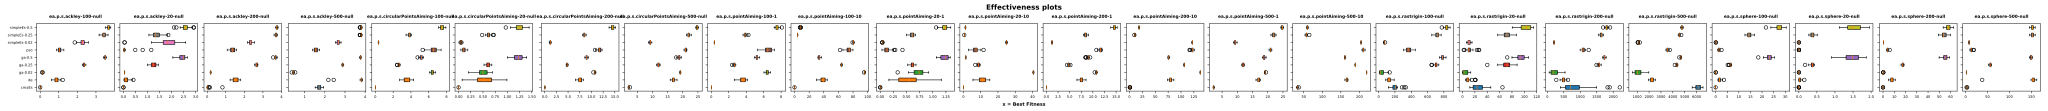

In [ ]:
################################################################################
# Effectiveness boxplots

# Some image settings
fig, axs = plt.subplots(1, len(problems), sharex=False, sharey=True, layout='constrained', figsize=(2*len(problems), 0.5*len(solvers)))
fig.suptitle('Effectiveness plots', fontsize=12, fontweight='bold')
fig.supxlabel('x = Best Fitness', fontsize=8, fontweight='bold')
big_title = experiment_name + "_EffectiveMatrix_"

for i, problem in enumerate(problems):

  # Specify the "problem" of each set of boxplots
  axs[i].set_title(problem, pad=10, weight='bold')

  # Collect data for each solver_sigma
  data_to_plot = []
  labels = []

  # Filter rows of the current problem
  pre_pre_filtered_data = united_CSV[united_CSV['problem'] == problem]

  for j, solver_sigma in enumerate(solvers_sigmas):

    # Filter the data for the current problem and solver_sigma
    pre_filtered_data = pre_pre_filtered_data[pre_pre_filtered_data['solver_sigma'] == solver_sigma]

    # Not all solvers has all values of sigma
    if pre_filtered_data.empty:
      continue

    # Find the maximum number of evaluations
    max_eval = pre_filtered_data['evals'].max()

    # Filter the data to only include the rows with the maximum number of evaluations
    filtered_data = pre_filtered_data[pre_filtered_data['evals'] == max_eval]

    # Append the 'best_fitness' data for the current solver_sigma to the list
    data_to_plot.append(filtered_data['best_fitness'].tolist())
    labels.append(solver_sigma)

  # Create the boxplot for the current problem
  bp = axs[i].boxplot(data_to_plot, patch_artist=True, vert=False)

  # Save data for LaTeX plots
  data_to_plot_transposed = list(map(list, zip(*data_to_plot)))
  df = pd.DataFrame(data_to_plot_transposed, columns=solvers_sigmas)
  df.to_csv("LaTeX/" + experiment_name + "/" + big_title + problem + '.txt', sep='\t', index=False)


  # Set the colors of the boxplot using the color map
  for patch, color in zip(bp['boxes'], color_map.colors[:len(solvers_sigmas)]):
    patch.set_facecolor(color)

  # Set the positions and labels of the y-ticks
  axs[i].set_yticks(range(1, len(labels) + 1))
  axs[i].set_yticklabels(labels)

# Saving image
plt.savefig('Figures/' + experiment_name + "/" + experiment_name + '_Effectiveness.png', bbox_inches='tight', transparent=False, dpi=600)

# Display image
plt.show()

In [ ]:
# Filter data to get only the last evaluation of each tuple (problem, solver, sigma, seed)
last_evals_df = united_CSV[united_CSV.groupby(['problem', 'solver_sigma_seed'])['evals'].transform(max) == united_CSV['evals']]

In [ ]:
################################################################################
# Number of victories score

# DataFrame for saving the binary effectiveness based on Wilcoxon's test (best vs other, pairwise)
binary_ranking_effectiveness_df = pd.DataFrame(index=problems, columns=solvers_sigmas)

for i, problem in enumerate(problems):

  # Filter the last evaluations of that problem
  filtered_data = last_evals_df[last_evals_df['problem']==problem]

  # Set the objective
  objective = filtered_data['objective'].iloc[0]

  # Check if is a max or min problem
  if objective == 'minimize':
    ascending = True
  elif objective == 'maximize':
    ascending = False
  else:
    raise ValueError('\"task_objective\" can be only \"minimize\" or \"maximize\"')

  # Compute the median effectiveness of each solver_sigma for the considered problem
  median_data = filtered_data.groupby('solver_sigma').median('best_fitness').sort_values('best_fitness', ascending=ascending)

  # Set the best solver_sigma for the considered problem
  best_solver_sigma = median_data.index[0]
  best_solver_sigma_df = filtered_data[filtered_data['solver_sigma']==best_solver_sigma]['best_fitness']

  # For each solver_sigma
  for j, solver_sigma in enumerate(solvers_sigmas):

    # If the current solver_sigma is the best, set its binary_ranking = 1
    if best_solver_sigma == solver_sigma:
      binary_ranking_effectiveness_df.at[problem, solver_sigma] = 1
      continue

    # For the others solvers_sigmas, filter
    other_solver_sigma_df = filtered_data[filtered_data['solver_sigma']==solver_sigma]['best_fitness']

    # For the other solvers_sigmas, perform the Wilcoxon test
    statistiche, p_value = wilcoxon(best_solver_sigma_df, other_solver_sigma_df)

    # Check p-value
    if p_value > level_significance:
      # No significant difference, so binary_rankin = 1
      binary_ranking_effectiveness_df.at[problem, solver_sigma] = 1
    else:
      # There is a significant difference, so binary_rankin = 0
      binary_ranking_effectiveness_df.at[problem, solver_sigma] = 0

# Compute the binary score
binary_score_effectiveness = binary_ranking_effectiveness_df.sum()
binary_score_effectiveness.name = "NOVS"
binary_ranking_df = pd.concat([binary_ranking_effectiveness_df, binary_score_effectiveness.to_frame().T])

# Save results in an xlsx file
binary_ranking_df.to_excel("XLSX Files/" + experiment_name + "/" + experiment_name + "_NOVS.xlsx")

# Visualize binary scores
print("          NOVS:\n")
print(binary_ranking_df.loc['NOVS'].sort_values(ascending=False))

          NOVS:

cmaEs            18
ga-0.02           6
simpleEs-0.02     2
de                0
ga-0.25           0
ga-0.5            0
pso               0
simpleEs-0.25     0
simpleEs-0.5      0
Name: NOVS, dtype: object


In [ ]:
################################################################################
# Number of victories score

# DataFrame for saving the binary effectiveness based on Wilcoxon's test (best vs other, pairwise)
binary_ranking_effectiveness_df = pd.DataFrame(index=problems, columns=solvers_sigmas)

for i, problem in enumerate(problems):

  # Filter the last evaluations of that problem
  filtered_data = last_evals_df[last_evals_df['problem']==problem]

  # Set the objective
  objective = filtered_data['objective'].iloc[0]

  # Check if is a max or min problem
  if objective == 'minimize':
    ascending = True
  elif objective == 'maximize':
    ascending = False
  else:
    raise ValueError('\"task_objective\" can be only \"minimize\" or \"maximize\"')

  # Compute the mean effectiveness of each solver_sigma for the considered problem
  mean_data = filtered_data.groupby('solver_sigma').mean('best_fitness').sort_values('best_fitness', ascending=ascending)

  # Set the best solver_sigma for the considered problem
  best_solver_sigma = mean_data.index[0]
  best_solver_sigma_df = filtered_data[filtered_data['solver_sigma']==best_solver_sigma]['best_fitness']

  # For each solver_sigma
  for j, solver_sigma in enumerate(solvers_sigmas):

    # If the current solver_sigma is the best, set its binary_ranking = 1
    if best_solver_sigma == solver_sigma:
      binary_ranking_effectiveness_df.at[problem, solver_sigma] = 1
      continue

    # For the others solvers_sigmas, filter
    other_solver_sigma_df = filtered_data[filtered_data['solver_sigma']==solver_sigma]['best_fitness']

    # For the other solvers_sigmas, perform the Wilcoxon test
    statistiche, p_value = wilcoxon(best_solver_sigma_df, other_solver_sigma_df)

    # Check p-value
    if p_value > level_significance:
      # No significant difference, so binary_rankin = 1
      binary_ranking_effectiveness_df.at[problem, solver_sigma] = 1
    else:
      # There is a significant difference, so binary_rankin = 0
      binary_ranking_effectiveness_df.at[problem, solver_sigma] = 0

# Compute the binary score
binary_score_effectiveness = binary_ranking_effectiveness_df.sum()
binary_score_effectiveness.name = "NOVS"
binary_ranking_df = pd.concat([binary_ranking_effectiveness_df, binary_score_effectiveness.to_frame().T])

# Save results in an xlsx file
binary_ranking_df.to_excel("XLSX Files/" + experiment_name + "/" + experiment_name + "_NOVS.xlsx")

# Visualize binary scores
print("          NOVS:\n")
print(binary_ranking_df.loc['NOVS'].sort_values(ascending=False))

          NOVS:

cmaEs            18
ga-0.02           6
simpleEs-0.02     2
de                0
ga-0.25           0
ga-0.5            0
pso               0
simpleEs-0.25     0
simpleEs-0.5      0
Name: NOVS, dtype: object


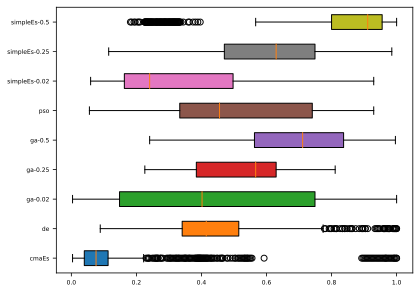

In [ ]:
################################################################################
# Normalized effectiveness ranking boxplots

# Rank (solver, sigma, seed) tuples by their effectiveness
effectiveness_ranking = np.full((len(problems), len(solvers_sigmas_seeds)), '', dtype=object)

# Store rankings on the fixed problem obtained by each cuple (solver, sigma)
solvers_sigmas__rankings = [[] for _ in range(len(solvers_sigmas))]

# Compute the normalization factor (the largest possible rank that can be obtained)
normalization_factor = len(solvers_sigmas) * len(seeds)

for i, problem in enumerate(problems):

  filtered_data = last_evals_df[last_evals_df['problem']==problem]

  objective = filtered_data['objective'].iloc[0]

  # Check if is a max or min problem
  if objective == 'minimize':
    ascending = True
  elif objective == 'maximize':
    ascending = False
  else:
    raise ValueError('\"task_objective\" can be only \"minimize\" or \"maximize\"')

  # Sort data
  sorted_data = filtered_data.sort_values('best_fitness', ascending=ascending)

  for j in range(len(solvers_sigmas_seeds)):

    # Rank (solver, sigma, seed) tuples by their effectiveness
    solver_sigma_seed = sorted_data['solver_sigma_seed'].iloc[j]

    solver_sigma = filtered_data[filtered_data['solver_sigma_seed'] == solver_sigma_seed]['solver_sigma'].iloc[0]

    # Store rankings obtained for each tuple
    index = solvers_sigmas.index(solver_sigma)
    solvers_sigmas__rankings[index].append((j + 1) / normalization_factor)

# Create the boxplot for the current problem
plt.figure()
bp = plt.boxplot(solvers_sigmas__rankings, patch_artist=True, vert=False, labels=solvers_sigmas)

# Save data for latex
data_to_plot_transposed = list(map(list, zip(*solvers_sigmas__rankings)))
df = pd.DataFrame(data_to_plot_transposed, columns=solvers_sigmas)
df.to_csv("LaTeX/" + experiment_name + "/" + "AAA_" + experiment_name + "_NER" + '.txt', sep='\t', index=False)

# Set the colors of the boxplot using the color map
for patch, color in zip(bp['boxes'], color_map.colors[:len(solvers_sigmas)]):
  patch.set_facecolor(color)

# Save image
plt.savefig("Figures/" + experiment_name + "/" + experiment_name + '_NER.png', bbox_inches='tight', transparent=False, dpi=600)

# Display image
plt.show()

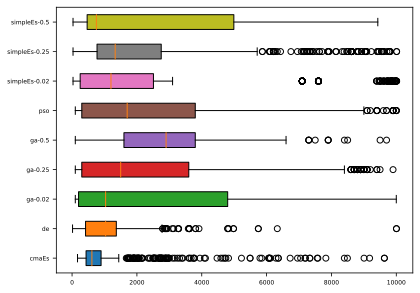

In [ ]:
################################################################################
# Efficiency boxplots

best_fitnesses_percentile = []

# Store rankings on the fixed problem obtained by each cuple (solver, sigma)
solvers_sigmas__first_eval_to_hit_threshold = [[] for _ in range(len(solvers_sigmas))]

for i, problem in enumerate(problems):

  current_problem_last_evals_df = last_evals_df[last_evals_df['problem']==problem].reset_index(drop=True)

  objective = current_problem_last_evals_df['objective'].iloc[0]

  # Check if is a max or min problem
  if objective == 'minimize':
    ascendingg = True
  elif objective == 'maximize':
    ascendingg = False
  else:
    raise ValueError('\"task_objective\" can be only \"minimize\" or \"maximize\"')

  # Sort data
  sorted_data = current_problem_last_evals_df.sort_values('best_fitness', ascending=ascendingg)

  current_index_percentile = int(efficiency_percentile_reference * len(sorted_data))
  current_problem_best_fitness_percentile = sorted_data.iloc[current_index_percentile]['best_fitness']

  best_fitnesses_percentile.append(current_problem_best_fitness_percentile)

  problem_filtered_data = united_CSV[(united_CSV['problem'] == problem)]

  for j, solver_sigma in enumerate(solvers_sigmas):

    # Filter the data for the current problem and solver_sigma
    solverSigma_filtered_data = problem_filtered_data[(problem_filtered_data['solver_sigma']==solver_sigma)]

    for k, seed in enumerate(seeds):

      # Filter the data for the current problem and solver_sigma and seed
      seed_filtered_data = solverSigma_filtered_data[(solverSigma_filtered_data['seed'] == seed)]

      # Check if the filtered data is empty
      if seed_filtered_data.empty:
        print(f"No data for problem={problem}, solver_sigma={solver_sigma}, seed={seed}")
        continue

      sorted_filtered_data = seed_filtered_data.sort_values('evals', ascending=True)
      if objective == 'minimize':
        for ii, row in sorted_filtered_data.iterrows():
          if row['best_fitness'] <= current_problem_best_fitness_percentile:
            current_best_fitness_percentile_evals = row['evals']
            break
      elif objective == 'maximize':
        for ii, row in sorted_filtered_data.iterrows():
          if row['best_fitness'] >= current_problem_best_fitness_percentile:
            current_best_fitness_percentile_evals = row['evals']
            break
      else:
        raise ValueError('\"task_objective\" can be only \"minimize\" or \"maximize\"')

      # Store rankings obtained for each tuple
      index = solvers_sigmas.index(solver_sigma)
      solvers_sigmas__first_eval_to_hit_threshold[index].append(current_best_fitness_percentile_evals)

# Create the boxplot for the current problem
plt.figure()
bp = plt.boxplot(solvers_sigmas__first_eval_to_hit_threshold, patch_artist=True, vert=False, labels=solvers_sigmas)

# Save data for LaTeX plots
data_to_plot_transposed = list(map(list, zip(*solvers_sigmas__first_eval_to_hit_threshold)))
df = pd.DataFrame(data_to_plot_transposed, columns=solvers_sigmas)
df.to_csv("LaTeX/" + experiment_name + "/" + "AAA_" + experiment_name + "_Efficiency_percentile-" + str(efficiency_percentile_reference) + '.txt', sep='\t', index=False)

# Set the colors of the boxplot using the color map
for patch, color in zip(bp['boxes'], color_map.colors[:len(solvers_sigmas)]):
  patch.set_facecolor(color)

# Saving image
plt.savefig("Figures/" + experiment_name + "/" + experiment_name + "_Efficiency_percentile-" + str(efficiency_percentile_reference) + '.png', bbox_inches='tight', transparent=False, dpi=600)

# Display image
plt.show()

In [ ]:
################################################################################
# Mean NER vs. genotype size (i.e., "p") plots

# Rank (solver, sigma, seed) tuples by their effectiveness
effectiveness_ranking = np.full((len(problems), len(solvers_sigmas_seeds)), '', dtype=object)

mean_NER = pd.DataFrame(index=problems, columns=solvers_sigmas)

# Add a column containing the "genotype_size" for each "problem"
genotype_size_series = last_evals_df.groupby('problem')['genotype_size'].first()
mean_NERs = pd.concat([genotype_size_series, mean_NER], axis=1)

for i, problem in enumerate(problems):

  filtered_data = last_evals_df[last_evals_df['problem']==problem]

  objective = filtered_data['objective'].iloc[0]

  # Check if is a max or min problem
  if objective == 'minimize':
    ascending = True
  elif objective == 'maximize':
    ascending = False
  else:
    raise ValueError('\"task_objective\" can be only \"minimize\" or \"maximize\"')

  # Sort data
  sorted_data = filtered_data.sort_values('best_fitness', ascending=ascending)

  # Store rankings on the fixed problem obtained by each cuple (solver, sigma)
  solvers_sigmas__rankings = [[] for _ in range(len(solvers_sigmas))]

  for j in range(len(solvers_sigmas_seeds)):

    # Rank (solver, sigma, seed) tuples by their effectiveness
    solver_sigma_seed = sorted_data['solver_sigma_seed'].iloc[j]
    effectiveness_ranking[i][j] = solver_sigma_seed

    solver_sigma = filtered_data[filtered_data['solver_sigma_seed'] == solver_sigma_seed]['solver_sigma'].iloc[0]

    # Store rankings obtained for each tuple
    index = solvers_sigmas.index(solver_sigma)
    solvers_sigmas__rankings[index].append(j + 1)

  for k, solver_sigma in enumerate(solvers_sigmas):
    current_mean_rank = statistics.mean(solvers_sigmas__rankings[k])
    current_normalized_mean_rank = current_mean_rank / (len(solvers_sigmas) * len(seeds))
    mean_NERs.loc[problem, solver_sigma] = current_normalized_mean_rank

# Save a .xlsx with mean NER and p for all problems
mean_NERs.to_excel("XLSX Files/" + experiment_name + "/" + experiment_name + "_meanNER-vs-p.xlsx")

# Compute the mean NER for fixed values of p
mean_NERs_sorted = mean_NERs.sort_values(by='genotype_size')
mean_NERs_grouped = mean_NERs_sorted.groupby("genotype_size").mean().reset_index()
# save results for LaTeX plots
mean_NERs_grouped.to_csv("LaTeX/" + experiment_name + "/" + "AAA_" + experiment_name + "_meanNER-vs-p" + '.txt', sep='\t', index=False)